## Deployment
### Import packages

In [59]:
#!/usr/bin/env python3
!pip install wget
import os
import torch
import torch.nn as nn
import numpy as np
import lightning.pytorch as pl 
import torchmetrics
import torchvision
from IPython.display import display 
import sympy as sp 
sp.init_printing(use_latex=True) 
import pandas as pd
import zipfile
if torch.cuda.is_available(): 
    print(torch.cuda.get_device_name()) 
    print(torch.cuda.get_device_properties("cuda")) 
    print("Number of devices:",torch.cuda.device_count()) 
    device = ("cuda")
else:
    print("Only CPU is available...") 
    device = ("cpu")

import random
import os
import matplotlib.pyplot as plt
import seaborn as sns
import zipfile
import sys
import time
import re
import wget
from PIL import Image
import torch.nn.functional as F
from keras.layers import Lambda
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

IMAGE_WIDTH = 256    
IMAGE_HEIGHT = 256
IMAGE_SIZE=(IMAGE_WIDTH, IMAGE_HEIGHT)
IMAGE_CHANNELS = 3

# Dictionary to save our 12 classes
categories = {0: 'paper', 1: 'cardboard', 2: 'plastic', 3: 'metal', 4: 'trash', 5: 'battery',
              6: 'shoes', 7: 'clothes', 8: 'green-glass', 9: 'brown-glass', 10: 'white-glass',
              11: 'biological'}

print('defining constants successful!')

Only CPU is available...
defining constants successful!


## Load a small data for deployment from AWS S3

In [60]:
url = 'https://danlee.s3.us-east-2.amazonaws.com/subsetdata/Subset.zip'
local_filename = 'subsetData'

try:
    wget.download(url, local_filename)
    print(f"File downloaded successfully to {local_filename}")
except Exception as e:
    print(f"Error downloading file: {e}")

extract_to_directory = 'subsetData_unzip'

# Open the zip file
with zipfile.ZipFile(local_filename, 'r') as zip_ref:
    # Extract all the contents to the specified directory
    zip_ref.extractall(extract_to_directory)

print(f"Successfully extracted contents to {extract_to_directory}")


File downloaded successfully to subsetData
Successfully extracted contents to subsetData_unzip


### after importing the data, the data path will be "Deployment/subsetData_unzip/Subset/"

In [61]:
base_path = r"subsetData_unzip/Subset/"
filenames_list = []
categories_list = []
filenames = os.listdir(base_path)

for i in range(len(filenames)):
    filenames_list.append(filenames[i])
    for key, category in categories.items():
        if category in str(filenames[i]):
            categories_list.append(key)
              
df = pd.DataFrame({
    'filename': filenames_list,
    'category': categories_list
})
print('number of elements = ', len(df))

path1 = r'deploydata.txt'
with open(path1, 'a') as f:
    df.to_csv('deploydata.txt', sep=' ', index=False, header = False)


number of elements =  120


### Gether information (image, label) into a .txt file

In [62]:
from torch.utils.data import Dataset
import torchvision.transforms as transforms 
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True


class Garbage_Loader_(Dataset):
    def __init__(self, txt_path, train_flag = True):
        self.imgs_info = self.get_images(txt_path)
        self.train_flag = train_flag
        self.train_tf = transforms.Compose([
                transforms.Resize((224,224)),
                transforms.ToTensor()
            ])
        self.val_tf = transforms.Compose([
                transforms.Resize((224,224)),
                transforms.ToTensor()
            ])
 
    def get_images(self, txt_path):
        with open(txt_path, 'r', encoding='utf-8') as f:
            imgs_info = f.readlines()
            imgs_info = list(map(lambda x:x.strip().split(" "), imgs_info))
            # print(imgs_info)
        return imgs_info
 
    def __getitem__(self, index):
        base_path = r"subsetData_unzip/Subset/"
        img_path, label = np.array(self.imgs_info[index])
        img_path = base_path+img_path
        # print(img_path)
        img = Image.open(img_path)
        img = img.convert('RGB')
        if self.train_flag:
            img = self.train_tf(img)
        else:
            img = self.val_tf(img)
        
        label = int(label)
        return img, label
 
    def __len__(self):
        return len(self.imgs_info)
        

deploy_data = Garbage_Loader_(path1, True)
print("Data Size", len(deploy_data))
inputsize = torch.Size([3, 224, 224])
num_class = 12

Data Size 120


## Define subset data prediction collection (load saved model weights)

In [63]:
!pip install prettytable
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import precision_score, recall_score, f1_score
from prettytable import PrettyTable
from sklearn.metrics import classification_report

def predict(test_dataset,model):
    pred = np.zeros((len(test_dataset),2))
    for i in range(len(test_dataset)):
        img,label = test_dataset[i]
        pred[i,0] = int(label)
        predictions = model(img.unsqueeze(0))
        probabilities = torch.softmax(predictions, dim=1)
        predicted_class = torch.argmax(probabilities).item()
        pred[i,1] = predicted_class
    return pred
    
def confusion_plot(pred):
    matrix = confusion_matrix(pred[:,0], pred[:,1])
    disp = ConfusionMatrixDisplay(confusion_matrix=matrix)
    disp.plot()
    plt.show()

def eval_acc(pred):
    correct_count = 0
    total_count = 0
    for i in range(pred.shape[0]):
        total_count += 1
        if(pred[i,0]==pred[i,1]):
            correct_count+=1
    acc = correct_count/total_count
    print("Accuracy: ",correct_count/total_count)
    return acc

def eval_class(pred):
    categories = {0: 'paper', 1: 'cardboard', 2: 'plastic', 3: 'metal', 4: 'trash', 5: 'battery',
              6: 'shoes', 7: 'clothes', 8: 'green-glass', 9: 'brown-glass', 10: 'white-glass',
              11: 'biological'}
    precision = precision_score(pred[:,0], pred[:,1], average=None)
    recall = recall_score(pred[:,0], pred[:,1], average=None)
    f1 = f1_score(pred[:,0], pred[:,1], average=None)
    categories = {0: 'paper', 1: 'cardboard', 2: 'plastic', 3: 'metal', 4: 'trash', 5: 'battery',
              6: 'shoes', 7: 'clothes', 8: 'green-glass', 9: 'brown-glass', 10: 'white-glass',
              11: 'biological'}
    report = classification_report(pred[:,0], pred[:,1], output_dict=True)
    table = PrettyTable()
    table.field_names = ["Class", "Precision", "Recall", "F1-score","support"]
    i = 0.0
    for class_label, metrics in report.items():
        if (i<=11):  # Check if it's a class (skip 'micro avg', 'macro avg', etc.)
            table.add_row([categories[i],
                               "{:.2f}".format(metrics['precision']),
                               "{:.2f}".format(metrics['recall']),
                               "{:.2f}".format(metrics['f1-score']),
                           "{:.0f}".format(metrics['support'])])
        i = i+1       
    print(table)


## AlexNet

In [64]:
import torchmetrics
import torchvision
import pytorch_lightning as pl
class AlexNet_Model(nn.Module):
    def __init__(self, num_classes=12):
        super(AlexNet_Model, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=11, stride=4, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2),
            nn.Conv2d(64, 192, kernel_size=5, stride=1,padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2),
            nn.Conv2d(192, 384, kernel_size=3,stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(384, 256, kernel_size=3,stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3,stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=0),
        )
        self.classifier = nn.Sequential(
            nn.Dropout(p=0.5),
            nn.Linear(9216, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.5),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, num_classes),
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x
        
        
class AlexNet(pl.LightningModule):
    def __init__(self, input_shape, output_size, **kwargs):
        super().__init__(**kwargs)

        self.normalize = torchvision.transforms.Compose([
            torchvision.transforms.Lambda(lambda x: x),
            torchvision.transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ])
        self.transform = torchvision.transforms.Compose([
            torchvision.transforms.RandomAffine(degrees=(-10.0, 10.0), translate=(0.1, 0.1),
                                              scale=(0.9, 1.1),
                                              shear=(-10.0, 10.0)),
            torchvision.transforms.RandomHorizontalFlip(0.5),
        ])

        # AlexNet_Model = torch.hub.load('pytorch/vision:v0.6.0', 'alexnet',pretrained = True)
        self.alex = AlexNet_Model().to(device)
        self.mc_acc = torchmetrics.classification.Accuracy(task='multiclass', num_classes=output_size)
        self.cce_loss = torch.nn.CrossEntropyLoss()

    def forward(self, x):
        # Always normalize
        x = self.normalize(x)
        # Only augment when training if self.training:
        x = self.transform(x)
        x = self.alex(x)
        return x

    def predict(self, x):
        return torch.softmax(self(x), -1)

    def configure_optimizers(self):
        optimizer = torch.optim.SGD(self.parameters(), lr=0.01, momentum=0.9)
        return optimizer

    def training_step(self, train_batch, batch_idx):
        x, y_true = train_batch
        y_pred = self(x)
        acc = self.mc_acc(y_pred, y_true)
        loss = self.cce_loss(y_pred, y_true)
        self.log('train_acc', acc, on_step=False, on_epoch=True)
        self.log('train_loss', loss, on_step=False, on_epoch=True)
        return loss

    def validation_step(self, val_batch, batch_idx):
        x, y_true = val_batch
        y_pred = self(x)
        acc = self.mc_acc(y_pred, y_true)
        loss = self.cce_loss(y_pred, y_true)
        self.log('val_acc', acc, on_step=False, on_epoch=True)
        self.log('val_loss', loss, on_step=False, on_epoch=True)
        return loss



### AlexNet-load weights file from AWS S3

In [66]:
url = 'https://danlee.s3.us-east-2.amazonaws.com/alex_weights.pth'
local_filename = 'weights/alex_weights.pth'

try:
    wget.download(url, local_filename)
    print(f"File downloaded successfully to {local_filename}")
except Exception as e:
    print(f"Error downloading file: {e}")

File downloaded successfully to weights/alex_weights.pth


### AlexNet model-build model, apply to delpoyment data, analyze prediction results

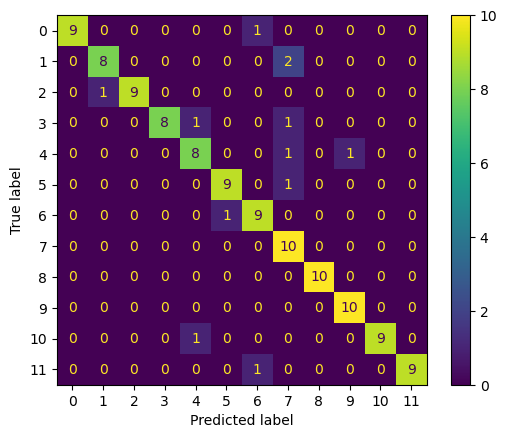

Accuracy:  0.9
+-------------+-----------+--------+----------+---------+
|    Class    | Precision | Recall | F1-score | support |
+-------------+-----------+--------+----------+---------+
|    paper    |    1.00   |  0.90  |   0.95   |    10   |
|  cardboard  |    0.89   |  0.80  |   0.84   |    10   |
|   plastic   |    1.00   |  0.90  |   0.95   |    10   |
|    metal    |    1.00   |  0.80  |   0.89   |    10   |
|    trash    |    0.80   |  0.80  |   0.80   |    10   |
|   battery   |    0.90   |  0.90  |   0.90   |    10   |
|    shoes    |    0.82   |  0.90  |   0.86   |    10   |
|   clothes   |    0.67   |  1.00  |   0.80   |    10   |
| green-glass |    1.00   |  1.00  |   1.00   |    10   |
| brown-glass |    0.91   |  1.00  |   0.95   |    10   |
| white-glass |    1.00   |  0.90  |   0.95   |    10   |
|  biological |    1.00   |  0.90  |   0.95   |    10   |
+-------------+-----------+--------+----------+---------+


In [67]:

model = AlexNet(inputsize, num_class)
model.load_state_dict(torch.load('weights/alex_weights.pth'))
model.eval()
alex_pred = predict(deploy_data,model)
confusion_plot(alex_pred)
acc_alex = eval_acc(alex_pred)
eval_class(alex_pred)

## GoogLeNet

In [68]:
class InceptionModule(nn.Module):
    def __init__(self, in_channels, ch1x1, ch3x3red, ch3x3, ch5x5red, ch5x5, pool_proj):
        super(InceptionModule, self).__init__()

        # 1x1 conv branch
        self.branch1 = nn.Conv2d(in_channels, ch1x1, kernel_size=1)

        # 1x1 conv -> 3x3 conv branch
        self.branch2 = nn.Sequential(
            nn.Conv2d(in_channels, ch3x3red, kernel_size=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(ch3x3red, ch3x3, kernel_size=3, padding=1)
        )

        # 1x1 conv -> 5x5 conv branch
        self.branch3 = nn.Sequential(
            nn.Conv2d(in_channels, ch5x5red, kernel_size=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(ch5x5red, ch5x5, kernel_size=5, padding=2)
        )

        # 3x3 pool -> 1x1 conv branch
        self.branch4 = nn.Sequential(
            nn.MaxPool2d(kernel_size=3, stride=1, padding=1),
            nn.Conv2d(in_channels, pool_proj, kernel_size=1)
        )

    def forward(self, x):
        branch1 = self.branch1(x)
        branch2 = self.branch2(x)
        branch3 = self.branch3(x)
        branch4 = self.branch4(x)
        outputs = [branch1, branch2, branch3, branch4]
        return torch.cat(outputs, 1)

class GoogleNet(nn.Module):
    def __init__(self, num_classes=12):
        super(GoogleNet, self).__init__()

        # First convolutional layer
        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3)
        self.maxpool1 = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        # Second convolutional layer
        self.conv2 = nn.Conv2d(64, 192, kernel_size=3, padding=1)
        self.maxpool2 = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        # Inception modules
        self.inception3a = InceptionModule(192, 64, 96, 128, 16, 32, 32)
        self.inception3b = InceptionModule(256, 128, 128, 192, 32, 96, 64)
        self.maxpool3 = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        self.inception4a = InceptionModule(480, 192, 96, 208, 16, 48, 64)
        self.inception4b = InceptionModule(512, 160, 112, 224, 24, 64, 64)
        self.inception4c = InceptionModule(512, 128, 128, 256, 24, 64, 64)
        self.inception4d = InceptionModule(512, 112, 144, 288, 32, 64, 64)
        self.inception4e = InceptionModule(528, 256, 160, 320, 32, 128, 128)
        self.maxpool4 = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        self.inception5a = InceptionModule(832, 256, 160, 320, 32, 128, 128)
        self.inception5b = InceptionModule(832, 384, 192, 384, 48, 128, 128)

        # Average pooling layer
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))

        # Fully connected layers
        self.fc1 = nn.Linear(1024, num_classes)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.maxpool1(x)
        x = F.relu(self.conv2(x))
        x = self.maxpool2(x)
        x = self.inception3a(x)
        x = self.inception3b(x)
        x = self.maxpool3(x)
        x = self.inception4a(x)
        x = self.inception4b(x)
        x = self.inception4c(x)
        x = self.inception4d(x)
        x = self.inception4e(x)
        x = self.maxpool4(x)
        x = self.inception5a(x)
        x = self.inception5b(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        return x

class google(pl.LightningModule):
    def __init__(self, input_shape, output_size, **kwargs):
        super().__init__(**kwargs)
        self.normalize = torchvision.transforms.Compose([
            torchvision.transforms.Lambda(lambda x: x),
            torchvision.transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ])

        self.transform = torchvision.transforms.Compose([
            torchvision.transforms.RandomAffine(degrees=(-10.0, 10.0), translate=(0.1, 0.1),
                                              scale=(0.9, 1.1),
                                              shear=(-10.0, 10.0)),
            torchvision.transforms.RandomHorizontalFlip(0.5),
        ])
        self.google = GoogleNet().to(device)
        self.mc_acc = torchmetrics.classification.Accuracy(task='multiclass', num_classes=output_size)
        self.cce_loss = torch.nn.CrossEntropyLoss()

    def forward(self, x):
        # Always normalize
        x = self.normalize(x)
        # Only augment when training if self.training:
        x = self.transform(x)
        x = self.google(x)
        return x

    def predict(self, x):
        return torch.softmax(self(x), -1)

    def configure_optimizers(self):
        optimizer = torch.optim.SGD(self.parameters(), lr=0.01, momentum=0.9)
        return optimizer

    def training_step(self, train_batch, batch_idx):
        x, y_true = train_batch
        y_pred = self(x)
        acc = self.mc_acc(y_pred, y_true)
        loss = self.cce_loss(y_pred, y_true)
        self.log('train_acc', acc, on_step=False, on_epoch=True)
        self.log('train_loss', loss, on_step=False, on_epoch=True)
        return loss

    def validation_step(self, val_batch, batch_idx):
        x, y_true = val_batch
        y_pred = self(x)
        acc = self.mc_acc(y_pred, y_true)
        loss = self.cce_loss(y_pred, y_true)
        self.log('val_acc', acc, on_step=False, on_epoch=True)
        self.log('val_loss', loss, on_step=False, on_epoch=True)
        return loss


### GoogLeNet model-load weights file from AWS S3

In [69]:
url = 'https://danlee.s3.us-east-2.amazonaws.com/google_weights.pth'
local_filename = 'weights/google_weights.pth'

try:
    wget.download(url, local_filename)
    print(f"File downloaded successfully to {local_filename}")
except Exception as e:
    print(f"Error downloading file: {e}")

File downloaded successfully to weights/google_weights.pth


### GoogLeNet model-build model, apply to delpoyment data, analyze prediction results

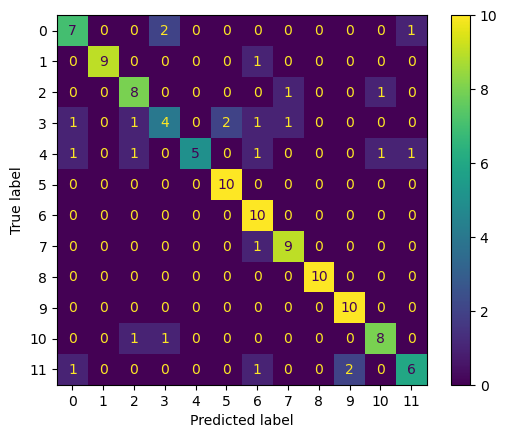

Accuracy:  0.8
+-------------+-----------+--------+----------+---------+
|    Class    | Precision | Recall | F1-score | support |
+-------------+-----------+--------+----------+---------+
|    paper    |    1.00   |  0.90  |   0.95   |    10   |
|  cardboard  |    0.89   |  0.80  |   0.84   |    10   |
|   plastic   |    1.00   |  0.90  |   0.95   |    10   |
|    metal    |    1.00   |  0.80  |   0.89   |    10   |
|    trash    |    0.80   |  0.80  |   0.80   |    10   |
|   battery   |    0.90   |  0.90  |   0.90   |    10   |
|    shoes    |    0.82   |  0.90  |   0.86   |    10   |
|   clothes   |    0.67   |  1.00  |   0.80   |    10   |
| green-glass |    1.00   |  1.00  |   1.00   |    10   |
| brown-glass |    0.91   |  1.00  |   0.95   |    10   |
| white-glass |    1.00   |  0.90  |   0.95   |    10   |
|  biological |    1.00   |  0.90  |   0.95   |    10   |
+-------------+-----------+--------+----------+---------+


In [70]:

model = google(inputsize, num_class)
model.load_state_dict(torch.load('weights/google_weights.pth'))
model.eval()
google_pred = predict(deploy_data,model)
confusion_plot(google_pred)
acc_google = eval_acc(google_pred)
eval_class(alex_pred)

## ResNet50-GeLU

In [71]:
# Modify activation function (relu-->gelu) in source code
try:
    from torch.hub import load_state_dict_from_url
except ImportError:
    from torch.utils.model_zoo import load_url as load_state_dict_from_url
    
__all__ = ['ResNet', 'resnet50']


model_urls = {
    'resnet50': 'https://download.pytorch.org/models/resnet50-19c8e357.pth'
}


def conv3x3(in_planes, out_planes, stride=1, groups=1, dilation=1):
    """3x3 convolution with padding"""
    return nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride,
                     padding=dilation, groups=groups, bias=False, dilation=dilation)


def conv1x1(in_planes, out_planes, stride=1):
    """1x1 convolution"""
    return nn.Conv2d(in_planes, out_planes, kernel_size=1, stride=stride, bias=False)

class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, inplanes, planes, stride=1, downsample=None, groups=1,
                 base_width=64, dilation=1, norm_layer=None):
        super(BasicBlock, self).__init__()
        if norm_layer is None:
            norm_layer = nn.BatchNorm2d
        if groups != 1 or base_width != 64:
            raise ValueError('BasicBlock only supports groups=1 and base_width=64')
        if dilation > 1:
            raise NotImplementedError("Dilation > 1 not supported in BasicBlock")
        # Both self.conv1 and self.downsample layers downsample the input when stride != 1
        self.conv1 = conv3x3(inplanes, planes, stride)
        self.bn1 = norm_layer(planes)
        self.gelu = nn.GELU()
        self.conv2 = conv3x3(planes, planes)
        self.bn2 = norm_layer(planes)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.gelu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.gelu(out)

        return out
class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, inplanes, planes, stride=1, downsample=None, groups=1,
                 base_width=64, dilation=1, norm_layer=None):
        super(Bottleneck, self).__init__()
        if norm_layer is None:
            norm_layer = nn.BatchNorm2d
        width = int(planes * (base_width / 64.)) * groups
        # Both self.conv2 and self.downsample layers downsample the input when stride != 1
        self.conv1 = conv1x1(inplanes, width)
        self.bn1 = norm_layer(width)
        self.conv2 = conv3x3(width, width, stride, groups, dilation)
        self.bn2 = norm_layer(width)
        self.conv3 = conv1x1(width, planes * self.expansion)
        self.bn3 = norm_layer(planes * self.expansion)
        self.gelu = nn.GELU()
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.gelu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.gelu(out)

        out = self.conv3(out)
        out = self.bn3(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.gelu(out)

        return out
class ResNet(nn.Module):
    def __init__(self, block, layers, num_classes=1000, zero_init_residual=False,
                 groups=1, width_per_group=64, replace_stride_with_dilation=None,
                 norm_layer=None):
        super(ResNet, self).__init__()
        if norm_layer is None:
            norm_layer = nn.BatchNorm2d
        self._norm_layer = norm_layer
        self.inplanes = 64
        self.dilation = 1
        if replace_stride_with_dilation is None:
            # each element in the tuple indicates if we should replace
            # the 2x2 stride with a dilated convolution instead
            replace_stride_with_dilation = [False, False, False]
        if len(replace_stride_with_dilation) != 3:
            raise ValueError("replace_stride_with_dilation should be None "
                             "or a 3-element tuple, got {}".format(replace_stride_with_dilation))
        self.groups = groups
        self.base_width = width_per_group
        self.conv1 = nn.Conv2d(3, self.inplanes, kernel_size=7, stride=2, padding=3,
                               bias=False)
        self.bn1 = norm_layer(self.inplanes)
        self.gelu = nn.GELU()
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2,
                                       dilate=replace_stride_with_dilation[0])
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2,
                                       dilate=replace_stride_with_dilation[1])
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2,
                                       dilate=replace_stride_with_dilation[2])
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512 * block.expansion, num_classes)
        if zero_init_residual:
            for m in self.modules():
                if isinstance(m, Bottleneck):
                    nn.init.constant_(m.bn3.weight, 0)
                elif isinstance(m, BasicBlock):
                    nn.init.constant_(m.bn2.weight, 0)

    def _make_layer(self, block, planes, blocks, stride=1, dilate=False):
        norm_layer = self._norm_layer
        downsample = None
        previous_dilation = self.dilation
        if dilate:
            self.dilation *= stride
            stride = 1
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                conv1x1(self.inplanes, planes * block.expansion, stride),
                norm_layer(planes * block.expansion),
            )

        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample, self.groups,
                            self.base_width, previous_dilation, norm_layer))
        self.inplanes = planes * block.expansion
        for _ in range(1, blocks):
            layers.append(block(self.inplanes, planes, groups=self.groups,
                                base_width=self.base_width, dilation=self.dilation,
                                norm_layer=norm_layer))

        return nn.Sequential(*layers)
    def _forward_impl(self, x):
        # See note [TorchScript super()]
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.gelu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        return x

    def forward(self, x):
        return self._forward_impl(x)

def _resnet(arch, block, layers, pretrained, progress, **kwargs):
    model = ResNet(block, layers, **kwargs)
    if pretrained:
        state_dict = load_state_dict_from_url(model_urls[arch],
                                              progress=progress)
        model.load_state_dict(state_dict)
    return model

def resnet50(pretrained=False, progress=True, **kwargs):
    r"""ResNet-50 model from
    `"Deep Residual Learning for Image Recognition" <https://arxiv.org/pdf/1512.03385.pdf>`_

    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
        progress (bool): If True, displays a progress bar of the download to stderr
    """
    return _resnet('resnet50', Bottleneck, [3, 4, 6, 3], pretrained, progress,
                   **kwargs)
class ResNet50(pl.LightningModule): 
    def __init__(self,input_shape, output_size, **kwargs):
        super().__init__(**kwargs)
        self.normalize = torchvision.transforms.Compose([
        torchvision.transforms.Lambda(lambda x: x), torchvision.transforms.Normalize(
            mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),])
    # Besides just scaling, the images can also undergo
    # augmentation using torchvision. Again, we compose
    # these operations together - ranges are provided for # each of these augmentations.
        self.transform = torchvision.transforms.Compose([
            torchvision.transforms.RandomAffine(degrees=(-10.0,10.0), translate=(0.1,0.1),
                                        scale=(0.9,1.1), 
                                        shear=(-10.0,10.0)),
            torchvision.transforms.RandomHorizontalFlip(0.5),])
        # self.projection = torch.nn.ConvTranspose2d(3,3, (4,4),(4,4)) # 8+
        # self.resnet = torchvision.models.resnet50(weights=None, num_classes=output_size)
        self.resnet = resnet50(num_classes=output_size)
        self.mc_acc = torchmetrics.classification.Accuracy(task='multiclass', num_classes=output_size)
        self.cce_loss = torch.nn.CrossEntropyLoss()
    def forward(self, x): 
        y=x
    # Always normalize
        y = self.normalize(y)
        # Only augment when training if self.training:
        y = self.transform(y) 
        # y = self.projection(y)
        y = self.resnet(y)
        return y
    def predict(self, x):
        return torch.softmax(self(x),-1)
    def configure_optimizers(self):
        optimizer = torch.optim.SGD(self.parameters(), lr=0.01, momentum = 0.9) 
        return optimizer
    def training_step(self, train_batch, batch_idx): 
        x, y_true = train_batch
        y_pred = self(x)
        acc = self.mc_acc(y_pred,y_true)
        loss = self.cce_loss(y_pred,y_true)
        self.log('train_acc', acc, on_step=False, on_epoch=True) 
        self.log('train_loss', loss, on_step=False, on_epoch=True) 
        return loss

    def validation_step(self, val_batch, batch_idx): 
        x, y_true = val_batch
        y_pred = self(x)
        acc = self.mc_acc(y_pred,y_true)
        loss = self.cce_loss(y_pred,y_true)
        self.log('val_acc', acc, on_step=False, on_epoch=True) 
        self.log('val_loss', loss, on_step=False, on_epoch=True) 
        return loss

### ResNet50-GeLU model-load weights file from AWS S3

In [72]:
url = 'https://danlee.s3.us-east-2.amazonaws.com/g50clr_weights.pth'
local_filename = 'weights/g50clr_weights.pth'

try:
    wget.download(url, local_filename)
    print(f"File downloaded successfully to {local_filename}")
except Exception as e:
    print(f"Error downloading file: {e}")

File downloaded successfully to weights/g50clr_weights.pth


### ResNet50-GeLU model-build model, apply to delpoyment data, analyze prediction results

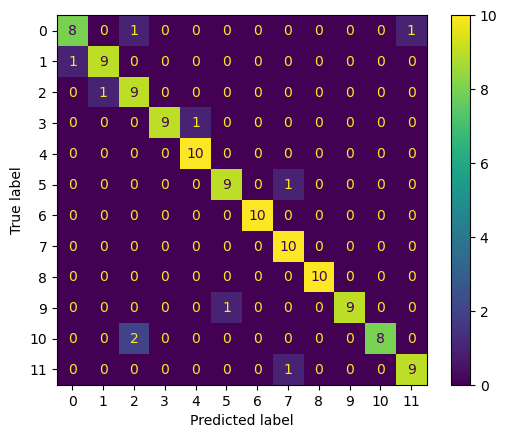

Accuracy:  0.9166666666666666
+-------------+-----------+--------+----------+---------+
|    Class    | Precision | Recall | F1-score | support |
+-------------+-----------+--------+----------+---------+
|    paper    |    0.89   |  0.80  |   0.84   |    10   |
|  cardboard  |    0.90   |  0.90  |   0.90   |    10   |
|   plastic   |    0.75   |  0.90  |   0.82   |    10   |
|    metal    |    1.00   |  0.90  |   0.95   |    10   |
|    trash    |    0.91   |  1.00  |   0.95   |    10   |
|   battery   |    0.90   |  0.90  |   0.90   |    10   |
|    shoes    |    1.00   |  1.00  |   1.00   |    10   |
|   clothes   |    0.83   |  1.00  |   0.91   |    10   |
| green-glass |    1.00   |  1.00  |   1.00   |    10   |
| brown-glass |    1.00   |  0.90  |   0.95   |    10   |
| white-glass |    1.00   |  0.80  |   0.89   |    10   |
|  biological |    0.90   |  0.90  |   0.90   |    10   |
+-------------+-----------+--------+----------+---------+


In [73]:
model = ResNet50(inputsize, num_class)
model.load_state_dict(torch.load('weights/g50clr_weights.pth'))
model.eval()
resGeLU_pred = predict(deploy_data,model)
confusion_plot(resGeLU_pred)
acc_resgelu = eval_acc(resGeLU_pred)
eval_class(resGeLU_pred)


## ResNet50-ReLU

In [74]:
class ResNet50(pl.LightningModule): 
    def __init__(self,input_shape, output_size, **kwargs):
        super().__init__(**kwargs)
        self.normalize = torchvision.transforms.Compose([
        torchvision.transforms.Lambda(lambda x: x), torchvision.transforms.Normalize(
            mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),])
    # Besides just scaling, the images can also undergo
    # augmentation using torchvision. Again, we compose
    # these operations together - ranges are provided for # each of these augmentations.
        self.transform = torchvision.transforms.Compose([
            torchvision.transforms.RandomAffine(degrees=(-10.0,10.0), translate=(0.1,0.1),
                                        scale=(0.9,1.1), 
                                        shear=(-10.0,10.0)),
            torchvision.transforms.RandomHorizontalFlip(0.5),])
        # self.projection = torch.nn.ConvTranspose2d(3,3, (4,4),(4,4)) # 8+
        self.resnet = torchvision.models.resnet50(weights=None, num_classes=output_size)
        self.mc_acc = torchmetrics.classification.Accuracy(task='multiclass', num_classes=output_size)
        self.cce_loss = torch.nn.CrossEntropyLoss()
    def forward(self, x): 
        y=x
    # Always normalize
        y = self.normalize(y)
        # Only augment when training if self.training:
        y = self.transform(y) 
        # y = self.projection(y)
        y = self.resnet(y)
        return y
    def predict(self, x):
        return torch.softmax(self(x),-1)
    def configure_optimizers(self):
        optimizer = torch.optim.SGD(self.parameters(), lr=0.01,momentum = 0.9) 
        return optimizer
    def training_step(self, train_batch, batch_idx): 
        x, y_true = train_batch
        y_pred = self(x)
        acc = self.mc_acc(y_pred,y_true)
        loss = self.cce_loss(y_pred,y_true)
        self.log('train_acc', acc, on_step=False, on_epoch=True) 
        self.log('train_loss', loss, on_step=False, on_epoch=True) 
        return loss

    def validation_step(self, val_batch, batch_idx): 
        x, y_true = val_batch
        y_pred = self(x)
        acc = self.mc_acc(y_pred,y_true)
        loss = self.cce_loss(y_pred,y_true)
        self.log('val_acc', acc, on_step=False, on_epoch=True) 
        self.log('val_loss', loss, on_step=False, on_epoch=True) 
        return loss

### ResNet50-ReLU model-load weights file from AWS S3

In [75]:
url = 'https://danlee.s3.us-east-2.amazonaws.com/r_weights.pth'
local_filename = 'weights/r_weights.pth'

try:
    wget.download(url, local_filename)
    print(f"File downloaded successfully to {local_filename}")
except Exception as e:
    print(f"Error downloading file: {e}")

File downloaded successfully to weights/r_weights.pth


### ResNet50-ReLU model-build model, apply to delpoyment data, analyze prediction results


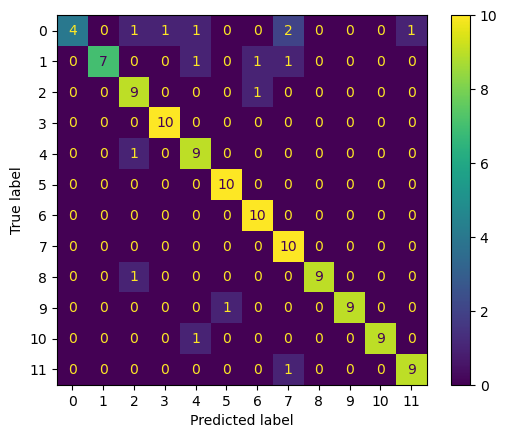

Accuracy:  0.875
+-------------+-----------+--------+----------+---------+
|    Class    | Precision | Recall | F1-score | support |
+-------------+-----------+--------+----------+---------+
|    paper    |    1.00   |  0.40  |   0.57   |    10   |
|  cardboard  |    1.00   |  0.70  |   0.82   |    10   |
|   plastic   |    0.75   |  0.90  |   0.82   |    10   |
|    metal    |    0.91   |  1.00  |   0.95   |    10   |
|    trash    |    0.75   |  0.90  |   0.82   |    10   |
|   battery   |    0.91   |  1.00  |   0.95   |    10   |
|    shoes    |    0.83   |  1.00  |   0.91   |    10   |
|   clothes   |    0.71   |  1.00  |   0.83   |    10   |
| green-glass |    1.00   |  0.90  |   0.95   |    10   |
| brown-glass |    1.00   |  0.90  |   0.95   |    10   |
| white-glass |    1.00   |  0.90  |   0.95   |    10   |
|  biological |    0.90   |  0.90  |   0.90   |    10   |
+-------------+-----------+--------+----------+---------+


In [76]:
model = ResNet50(inputsize, num_class)
model.load_state_dict(torch.load('weights/r_weights.pth'))
model.eval()
resReLU_pred = predict(deploy_data,model)
confusion_plot(resReLU_pred)
acc_resrelu = eval_acc(resReLU_pred)
eval_class(resReLU_pred)

## ResNet50-Leaky ReLU

In [78]:
# Modify activation function (relu-->leaky relu) in source code
try:
    from torch.hub import load_state_dict_from_url
except ImportError:
    from torch.utils.model_zoo import load_url as load_state_dict_from_url
    
__all__ = ['ResNet', 'resnet50']


model_urls = {
    'resnet50': 'https://download.pytorch.org/models/resnet50-19c8e357.pth'
}


def conv3x3(in_planes, out_planes, stride=1, groups=1, dilation=1):
    """3x3 convolution with padding"""
    return nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride,
                     padding=dilation, groups=groups, bias=False, dilation=dilation)


def conv1x1(in_planes, out_planes, stride=1):
    """1x1 convolution"""
    return nn.Conv2d(in_planes, out_planes, kernel_size=1, stride=stride, bias=False)

class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, inplanes, planes, stride=1, downsample=None, groups=1,
                 base_width=64, dilation=1, norm_layer=None):
        super(BasicBlock, self).__init__()
        if norm_layer is None:
            norm_layer = nn.BatchNorm2d
        if groups != 1 or base_width != 64:
            raise ValueError('BasicBlock only supports groups=1 and base_width=64')
        if dilation > 1:
            raise NotImplementedError("Dilation > 1 not supported in BasicBlock")
        # Both self.conv1 and self.downsample layers downsample the input when stride != 1
        self.conv1 = conv3x3(inplanes, planes, stride)
        self.bn1 = norm_layer(planes)
        self.leakyReLU = nn.LeakyReLU()
        self.conv2 = conv3x3(planes, planes)
        self.bn2 = norm_layer(planes)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.leakyReLU(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.leakyReLU(out)

        return out
class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, inplanes, planes, stride=1, downsample=None, groups=1,
                 base_width=64, dilation=1, norm_layer=None):
        super(Bottleneck, self).__init__()
        if norm_layer is None:
            norm_layer = nn.BatchNorm2d
        width = int(planes * (base_width / 64.)) * groups
        # Both self.conv2 and self.downsample layers downsample the input when stride != 1
        self.conv1 = conv1x1(inplanes, width)
        self.bn1 = norm_layer(width)
        self.conv2 = conv3x3(width, width, stride, groups, dilation)
        self.bn2 = norm_layer(width)
        self.conv3 = conv1x1(width, planes * self.expansion)
        self.bn3 = norm_layer(planes * self.expansion)
        self.leakyReLU = nn.LeakyReLU()
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.leakyReLU(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.leakyReLU(out)

        out = self.conv3(out)
        out = self.bn3(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.leakyReLU(out)

        return out
class ResNet(nn.Module):
    def __init__(self, block, layers, num_classes=1000, zero_init_residual=False,
                 groups=1, width_per_group=64, replace_stride_with_dilation=None,
                 norm_layer=None):
        super(ResNet, self).__init__()
        if norm_layer is None:
            norm_layer = nn.BatchNorm2d
        self._norm_layer = norm_layer
        self.inplanes = 64
        self.dilation = 1
        if replace_stride_with_dilation is None:
            # each element in the tuple indicates if we should replace
            # the 2x2 stride with a dilated convolution instead
            replace_stride_with_dilation = [False, False, False]
        if len(replace_stride_with_dilation) != 3:
            raise ValueError("replace_stride_with_dilation should be None "
                             "or a 3-element tuple, got {}".format(replace_stride_with_dilation))
        self.groups = groups
        self.base_width = width_per_group
        self.conv1 = nn.Conv2d(3, self.inplanes, kernel_size=7, stride=2, padding=3,
                               bias=False)
        self.bn1 = norm_layer(self.inplanes)
        self.leakyReLU = nn.LeakyReLU()
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2,
                                       dilate=replace_stride_with_dilation[0])
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2,
                                       dilate=replace_stride_with_dilation[1])
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2,
                                       dilate=replace_stride_with_dilation[2])
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512 * block.expansion, num_classes)

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='leaky_relu')
            elif isinstance(m, (nn.BatchNorm2d, nn.GroupNorm)):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

        # Zero-initialize the last BN in each residual branch,
        # so that the residual branch starts with zeros, and each residual block behaves like an identity.
        # This improves the model by 0.2~0.3% according to https://arxiv.org/abs/1706.02677
        if zero_init_residual:
            for m in self.modules():
                if isinstance(m, Bottleneck):
                    nn.init.constant_(m.bn3.weight, 0)
                elif isinstance(m, BasicBlock):
                    nn.init.constant_(m.bn2.weight, 0)

    def _make_layer(self, block, planes, blocks, stride=1, dilate=False):
        norm_layer = self._norm_layer
        downsample = None
        previous_dilation = self.dilation
        if dilate:
            self.dilation *= stride
            stride = 1
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                conv1x1(self.inplanes, planes * block.expansion, stride),
                norm_layer(planes * block.expansion),
            )

        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample, self.groups,
                            self.base_width, previous_dilation, norm_layer))
        self.inplanes = planes * block.expansion
        for _ in range(1, blocks):
            layers.append(block(self.inplanes, planes, groups=self.groups,
                                base_width=self.base_width, dilation=self.dilation,
                                norm_layer=norm_layer))

        return nn.Sequential(*layers)
    def _forward_impl(self, x):
        # See note [TorchScript super()]
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.leakyReLU(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        return x

    def forward(self, x):
        return self._forward_impl(x)

def _resnet(arch, block, layers, pretrained, progress, **kwargs):
    model = ResNet(block, layers, **kwargs)
    if pretrained:
        state_dict = load_state_dict_from_url(model_urls[arch],
                                              progress=progress)
        model.load_state_dict(state_dict)
    return model

def resnet50(pretrained=False, progress=True, **kwargs):
    r"""ResNet-50 model from
    `"Deep Residual Learning for Image Recognition" <https://arxiv.org/pdf/1512.03385.pdf>`_

    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
        progress (bool): If True, displays a progress bar of the download to stderr
    """
    return _resnet('resnet50', Bottleneck, [3, 4, 6, 3], pretrained, progress,
                   **kwargs)
class ResNet50(pl.LightningModule): 
    def __init__(self,input_shape, output_size, **kwargs):
        super().__init__(**kwargs)
        self.normalize = torchvision.transforms.Compose([
        torchvision.transforms.Lambda(lambda x: x), torchvision.transforms.Normalize(
            mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),])
    # Besides just scaling, the images can also undergo
    # augmentation using torchvision. Again, we compose
    # these operations together - ranges are provided for # each of these augmentations.
        self.transform = torchvision.transforms.Compose([
            torchvision.transforms.RandomAffine(degrees=(-10.0,10.0), translate=(0.1,0.1),
                                        scale=(0.9,1.1), 
                                        shear=(-10.0,10.0)),
            torchvision.transforms.RandomHorizontalFlip(0.5),])
        # self.resnet = torchvision.models.resnet50(weights=None, num_classes=output_size)
        self.resnet = resnet50(num_classes=output_size)
        self.mc_acc = torchmetrics.classification.Accuracy(task='multiclass', num_classes=output_size)
        self.cce_loss = torch.nn.CrossEntropyLoss()
    def forward(self, x): 
        y=x
    # Always normalize
        y = self.normalize(y)
        # Only augment when training if self.training:
        y = self.transform(y) 
        y = self.resnet(y)
        return y
    def predict(self, x):
        return torch.softmax(self(x),-1)
    def configure_optimizers(self):
        optimizer = torch.optim.SGD(self.parameters(), lr=0.01,momentum = 0.9) 
        return optimizer
    def training_step(self, train_batch, batch_idx): 
        x, y_true = train_batch
        y_pred = self(x)
        acc = self.mc_acc(y_pred,y_true)
        loss = self.cce_loss(y_pred,y_true)
        self.log('train_acc', acc, on_step=False, on_epoch=True) 
        self.log('train_loss', loss, on_step=False, on_epoch=True) 
        return loss

    def validation_step(self, val_batch, batch_idx): 
        x, y_true = val_batch
        y_pred = self(x)
        acc = self.mc_acc(y_pred,y_true)
        loss = self.cce_loss(y_pred,y_true)
        self.log('val_acc', acc, on_step=False, on_epoch=True) 
        self.log('val_loss', loss, on_step=False, on_epoch=True) 
        return loss

### ResNet50-Leaky ReLU-load weights file from AWS S3

In [79]:
url = 'https://danlee.s3.us-east-2.amazonaws.com/lr_weights.pth'
local_filename = 'weights/lr_weights.pth'

try:
    wget.download(url, local_filename)
    print(f"File downloaded successfully to {local_filename}")
except Exception as e:
    print(f"Error downloading file: {e}")

File downloaded successfully to weights/lr_weights.pth


### ResNet50-Leaky ReLU model-build model, apply to delpoyment data, analyze prediction results


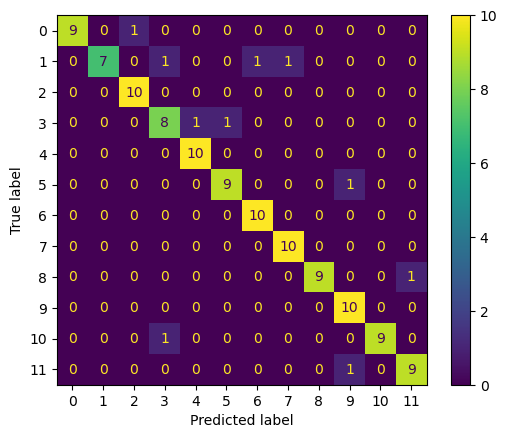

Accuracy:  0.9166666666666666
+-------------+-----------+--------+----------+---------+
|    Class    | Precision | Recall | F1-score | support |
+-------------+-----------+--------+----------+---------+
|    paper    |    1.00   |  0.90  |   0.95   |    10   |
|  cardboard  |    1.00   |  0.70  |   0.82   |    10   |
|   plastic   |    0.91   |  1.00  |   0.95   |    10   |
|    metal    |    0.80   |  0.80  |   0.80   |    10   |
|    trash    |    0.91   |  1.00  |   0.95   |    10   |
|   battery   |    0.90   |  0.90  |   0.90   |    10   |
|    shoes    |    0.91   |  1.00  |   0.95   |    10   |
|   clothes   |    0.91   |  1.00  |   0.95   |    10   |
| green-glass |    1.00   |  0.90  |   0.95   |    10   |
| brown-glass |    0.83   |  1.00  |   0.91   |    10   |
| white-glass |    1.00   |  0.90  |   0.95   |    10   |
|  biological |    0.90   |  0.90  |   0.90   |    10   |
+-------------+-----------+--------+----------+---------+


In [80]:
model = ResNet50(inputsize, num_class)
model.load_state_dict(torch.load('weights/lr_weights.pth'))
model.eval()
resLReLU_pred = predict(deploy_data,model)
confusion_plot(resLReLU_pred)
acc_reslrelu = eval_acc(resLReLU_pred)
eval_class(resLReLU_pred)

## ResNet50-GeLU-stepLR
### Epoch 50 vs. Epoch 80

In [81]:
# Modify activation function (relu-->gelu) in source code
try:
    from torch.hub import load_state_dict_from_url
except ImportError:
    from torch.utils.model_zoo import load_url as load_state_dict_from_url
    
__all__ = ['ResNet', 'resnet50']


model_urls = {
    'resnet50': 'https://download.pytorch.org/models/resnet50-19c8e357.pth'
}


def conv3x3(in_planes, out_planes, stride=1, groups=1, dilation=1):
    """3x3 convolution with padding"""
    return nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride,
                     padding=dilation, groups=groups, bias=False, dilation=dilation)


def conv1x1(in_planes, out_planes, stride=1):
    """1x1 convolution"""
    return nn.Conv2d(in_planes, out_planes, kernel_size=1, stride=stride, bias=False)

class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, inplanes, planes, stride=1, downsample=None, groups=1,
                 base_width=64, dilation=1, norm_layer=None):
        super(BasicBlock, self).__init__()
        if norm_layer is None:
            norm_layer = nn.BatchNorm2d
        if groups != 1 or base_width != 64:
            raise ValueError('BasicBlock only supports groups=1 and base_width=64')
        if dilation > 1:
            raise NotImplementedError("Dilation > 1 not supported in BasicBlock")
        # Both self.conv1 and self.downsample layers downsample the input when stride != 1
        self.conv1 = conv3x3(inplanes, planes, stride)
        self.bn1 = norm_layer(planes)
        self.gelu = nn.GELU()
        self.conv2 = conv3x3(planes, planes)
        self.bn2 = norm_layer(planes)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.gelu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.gelu(out)

        return out
class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, inplanes, planes, stride=1, downsample=None, groups=1,
                 base_width=64, dilation=1, norm_layer=None):
        super(Bottleneck, self).__init__()
        if norm_layer is None:
            norm_layer = nn.BatchNorm2d
        width = int(planes * (base_width / 64.)) * groups
        # Both self.conv2 and self.downsample layers downsample the input when stride != 1
        self.conv1 = conv1x1(inplanes, width)
        self.bn1 = norm_layer(width)
        self.conv2 = conv3x3(width, width, stride, groups, dilation)
        self.bn2 = norm_layer(width)
        self.conv3 = conv1x1(width, planes * self.expansion)
        self.bn3 = norm_layer(planes * self.expansion)
        self.gelu = nn.GELU()
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.gelu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.gelu(out)

        out = self.conv3(out)
        out = self.bn3(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.gelu(out)

        return out
class ResNet(nn.Module):
    def __init__(self, block, layers, num_classes=1000, zero_init_residual=False,
                 groups=1, width_per_group=64, replace_stride_with_dilation=None,
                 norm_layer=None):
        super(ResNet, self).__init__()
        if norm_layer is None:
            norm_layer = nn.BatchNorm2d
        self._norm_layer = norm_layer
        self.inplanes = 64
        self.dilation = 1
        if replace_stride_with_dilation is None:
            replace_stride_with_dilation = [False, False, False]
        if len(replace_stride_with_dilation) != 3:
            raise ValueError("replace_stride_with_dilation should be None "
                             "or a 3-element tuple, got {}".format(replace_stride_with_dilation))
        self.groups = groups
        self.base_width = width_per_group
        self.conv1 = nn.Conv2d(3, self.inplanes, kernel_size=7, stride=2, padding=3,
                               bias=False)
        self.bn1 = norm_layer(self.inplanes)
        self.gelu = nn.GELU()
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2,
                                       dilate=replace_stride_with_dilation[0])
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2,
                                       dilate=replace_stride_with_dilation[1])
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2,
                                       dilate=replace_stride_with_dilation[2])
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512 * block.expansion, num_classes)
        if zero_init_residual:
            for m in self.modules():
                if isinstance(m, Bottleneck):
                    nn.init.constant_(m.bn3.weight, 0)
                elif isinstance(m, BasicBlock):
                    nn.init.constant_(m.bn2.weight, 0)

    def _make_layer(self, block, planes, blocks, stride=1, dilate=False):
        norm_layer = self._norm_layer
        downsample = None
        previous_dilation = self.dilation
        if dilate:
            self.dilation *= stride
            stride = 1
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                conv1x1(self.inplanes, planes * block.expansion, stride),
                norm_layer(planes * block.expansion),
            )

        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample, self.groups,
                            self.base_width, previous_dilation, norm_layer))
        self.inplanes = planes * block.expansion
        for _ in range(1, blocks):
            layers.append(block(self.inplanes, planes, groups=self.groups,
                                base_width=self.base_width, dilation=self.dilation,
                                norm_layer=norm_layer))

        return nn.Sequential(*layers)
    def _forward_impl(self, x):
        # See note [TorchScript super()]
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.gelu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        return x

    def forward(self, x):
        return self._forward_impl(x)

def _resnet(arch, block, layers, pretrained, progress, **kwargs):
    model = ResNet(block, layers, **kwargs)
    if pretrained:
        state_dict = load_state_dict_from_url(model_urls[arch],
                                              progress=progress)
        model.load_state_dict(state_dict)
    return model

def resnet50(pretrained=False, progress=True, **kwargs):
    r"""ResNet-50 model from
    `"Deep Residual Learning for Image Recognition" <https://arxiv.org/pdf/1512.03385.pdf>`_

    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
        progress (bool): If True, displays a progress bar of the download to stderr
    """
    return _resnet('resnet50', Bottleneck, [3, 4, 6, 3], pretrained, progress,
                   **kwargs)
class ResNet50(pl.LightningModule): 
    def __init__(self,input_shape, output_size, **kwargs):
        super().__init__(**kwargs)
        self.normalize = torchvision.transforms.Compose([
        torchvision.transforms.Lambda(lambda x: x), torchvision.transforms.Normalize(
            mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),])
        self.transform = torchvision.transforms.Compose([
            torchvision.transforms.RandomAffine(degrees=(-10.0,10.0), translate=(0.1,0.1),
                                        scale=(0.9,1.1), 
                                        shear=(-10.0,10.0)),
            torchvision.transforms.RandomHorizontalFlip(0.5),])
        self.resnet = resnet50(num_classes=output_size)
        self.mc_acc = torchmetrics.classification.Accuracy(task='multiclass', num_classes=output_size)
        self.cce_loss = torch.nn.CrossEntropyLoss()
    def forward(self, x): 
        y=x
    # Always normalize
        y = self.normalize(y)
        # Only augment when training if self.training:
        y = self.transform(y) 
        # y = self.projection(y)
        y = self.resnet(y)
        return y
    def predict(self, x):
        return torch.softmax(self(x),-1)
        
    def configure_optimizers(self):
        optimizer = torch.optim.SGD(self.parameters(), lr=0.015, momentum = 0.9) 
        scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.9) 
        # return optimizer
        return {"optimizer": optimizer, "lr_scheduler": scheduler}
    def training_step(self, train_batch, batch_idx): 
        x, y_true = train_batch
        y_pred = self(x)
        acc = self.mc_acc(y_pred,y_true)
        loss = self.cce_loss(y_pred,y_true)
        self.log('train_acc', acc, on_step=False, on_epoch=True) 
        self.log('train_loss', loss, on_step=False, on_epoch=True) 
        return loss

    def validation_step(self, val_batch, batch_idx): 
        x, y_true = val_batch
        y_pred = self(x)
        acc = self.mc_acc(y_pred,y_true)
        loss = self.cce_loss(y_pred,y_true)
        self.log('val_acc', acc, on_step=False, on_epoch=True) 
        self.log('val_loss', loss, on_step=False, on_epoch=True) 
        return loss

### Epoch 50
### ResNet50-GeLU StepLR model-load weights file from AWS S3

In [82]:
url = 'https://danlee.s3.us-east-2.amazonaws.com/g50_weights.pth'
local_filename = 'weights/g50_weights.pth'

try:
    wget.download(url, local_filename)
    print(f"File downloaded successfully to {local_filename}")
except Exception as e:
    print(f"Error downloading file: {e}")

File downloaded successfully to weights/g50_weights.pth


### ResNet50-GeLU StepLR model-build model, apply to delpoyment data, analyze prediction results

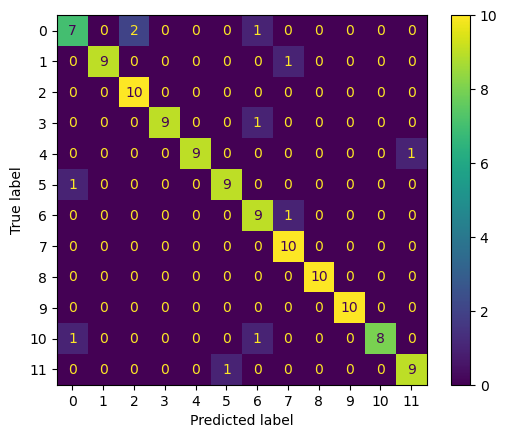

Accuracy:  0.9083333333333333
+-------------+-----------+--------+----------+---------+
|    Class    | Precision | Recall | F1-score | support |
+-------------+-----------+--------+----------+---------+
|    paper    |    0.78   |  0.70  |   0.74   |    10   |
|  cardboard  |    1.00   |  0.90  |   0.95   |    10   |
|   plastic   |    0.83   |  1.00  |   0.91   |    10   |
|    metal    |    1.00   |  0.90  |   0.95   |    10   |
|    trash    |    1.00   |  0.90  |   0.95   |    10   |
|   battery   |    0.90   |  0.90  |   0.90   |    10   |
|    shoes    |    0.75   |  0.90  |   0.82   |    10   |
|   clothes   |    0.83   |  1.00  |   0.91   |    10   |
| green-glass |    1.00   |  1.00  |   1.00   |    10   |
| brown-glass |    1.00   |  1.00  |   1.00   |    10   |
| white-glass |    1.00   |  0.80  |   0.89   |    10   |
|  biological |    0.90   |  0.90  |   0.90   |    10   |
+-------------+-----------+--------+----------+---------+


In [83]:
model = ResNet50(inputsize, num_class)
model.load_state_dict(torch.load('weights/g50_weights.pth'))
model.eval()
resGeLU_pred = predict(deploy_data,model)
confusion_plot(resGeLU_pred)
acc_steplr50 = eval_acc(resGeLU_pred)
eval_class(resGeLU_pred)


### Epoch 80

In [84]:
url = 'https://danlee.s3.us-east-2.amazonaws.com/g80_weights.pth'
local_filename = 'weights/g80_weights.pth'

try:
    wget.download(url, local_filename)
    print(f"File downloaded successfully to {local_filename}")
except Exception as e:
    print(f"Error downloading file: {e}")

File downloaded successfully to weights/g80_weights.pth


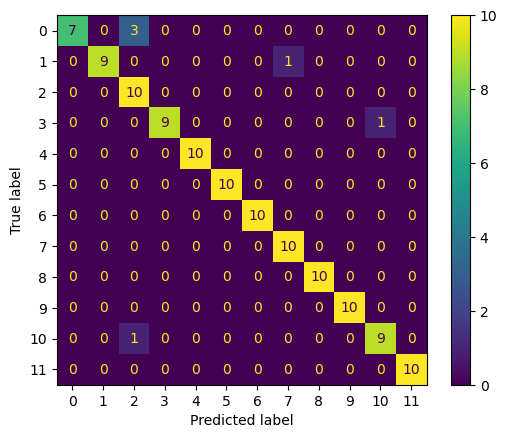

Accuracy:  0.95
+-------------+-----------+--------+----------+---------+
|    Class    | Precision | Recall | F1-score | support |
+-------------+-----------+--------+----------+---------+
|    paper    |    1.00   |  0.70  |   0.82   |    10   |
|  cardboard  |    1.00   |  0.90  |   0.95   |    10   |
|   plastic   |    0.71   |  1.00  |   0.83   |    10   |
|    metal    |    1.00   |  0.90  |   0.95   |    10   |
|    trash    |    1.00   |  1.00  |   1.00   |    10   |
|   battery   |    1.00   |  1.00  |   1.00   |    10   |
|    shoes    |    1.00   |  1.00  |   1.00   |    10   |
|   clothes   |    0.91   |  1.00  |   0.95   |    10   |
| green-glass |    1.00   |  1.00  |   1.00   |    10   |
| brown-glass |    1.00   |  1.00  |   1.00   |    10   |
| white-glass |    0.90   |  0.90  |   0.90   |    10   |
|  biological |    1.00   |  1.00  |   1.00   |    10   |
+-------------+-----------+--------+----------+---------+


In [85]:
model = ResNet50(inputsize, num_class)
model.load_state_dict(torch.load('weights/g80_weights.pth'))
model.eval()
resGeLU_pred = predict(deploy_data,model)
confusion_plot(resGeLU_pred)
acc_steplr80 = eval_acc(resGeLU_pred)
eval_class(resGeLU_pred)

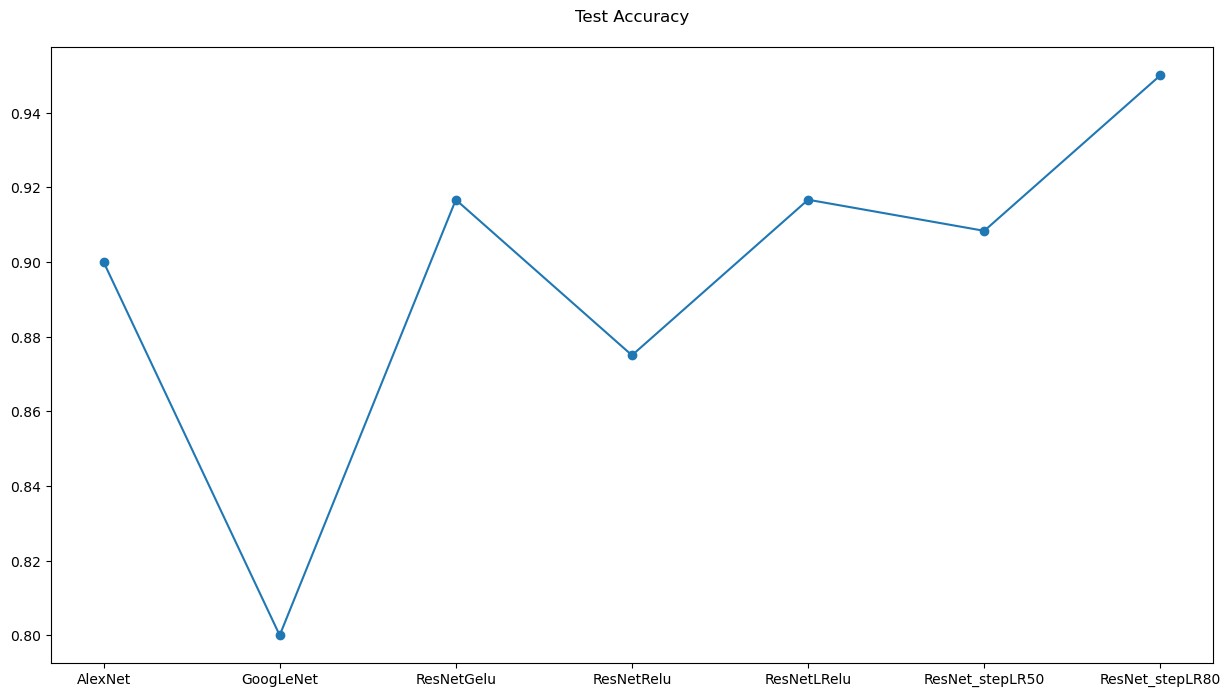

In [86]:
plt.figure(figsize=(15,8))
model_list = ["AlexNet", "GoogLeNet", "ResNetGelu","ResNetRelu","ResNetLRelu","ResNet_stepLR50","ResNet_stepLR80"]
acc_list = [acc_alex,acc_google,acc_resgelu,acc_resrelu,acc_reslrelu,acc_steplr50,acc_steplr80]
plt.title("Test Accuracy\n")
plt.plot(model_list,acc_list,"-o")
plt.show()